In [ ]:
import numpy as np
import os
import pickle
from tqdm import tqdm
import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, add, LSTM, Embedding, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/VizWiz Code/extracted

/content/drive/.shortcut-targets-by-id/1nWIRZlxjsKqHOr4tyiczwVJmz6NEqO8Q/VizWiz Code/extracted


In [ ]:
!pip install unrar
!unrar x '/content/drive/MyDrive/VizWiz Code/VizWiz Dataset.rar'

In [ ]:
base_dir = '/content/drive/MyDrive/VizWiz Code/extracted/VizWiz Dataset'
train_img_dir = os.path.join(base_dir, 'train')
val_img_dir = os.path.join(base_dir, 'val')
test_img_dir = os.path.join(base_dir, 'test')
train_annot_dir = os.path.join(os.path.join(base_dir, 'annotations'), 'train.json')
val_annot_dir = os.path.join(os.path.join(base_dir, 'annotations'), 'val.json')
test_annot_dir = os.path.join(os.path.join(base_dir, 'annotations'), 'test.json')

In [ ]:
import json

with open(train_annot_dir, 'r') as file:
    train_dict = json.load(file)

with open(val_annot_dir, 'r') as file:
    val_dict = json.load(file)

with open(test_annot_dir, 'r') as file:
    test_dict = json.load(file)

In [ ]:
loaded_data_path = '/content/drive/MyDrive/VizWiz Code/loaded_data'

In [ ]:
import pickle 
pickle.dump(train_dict, open(os.path.join(loaded_data_path, 'train_dict.pkl'), 'wb'))
pickle.dump(val_dict, open(os.path.join(loaded_data_path, 'val_dict.pkl'), 'wb'))
pickle.dump(test_dict, open(os.path.join(loaded_data_path, 'test_dict.pkl'), 'wb'))

In [ ]:
with open(os.path.join(loaded_data_path, 'train_dict.pkl'), 'rb') as f:
  train_dict = pickle.load(f)
with open(os.path.join(loaded_data_path, 'val_dict.pkl'), 'rb') as f:
  val_dict = pickle.load(f)
with open(os.path.join(loaded_data_path, 'test_dict.pkl'), 'rb') as f:
  test_dict = pickle.load(f)

In [ ]:
train_img_mapping = {}

for indiv_dict in train_dict['images']:
    img_name = indiv_dict['file_name']
    img_id = indiv_dict['id']
    train_img_mapping[img_name] = img_id

In [ ]:
val_img_mapping = {}

for indiv_dict in val_dict['images']:
    img_name = indiv_dict['file_name']
    img_id = indiv_dict['id']
    val_img_mapping[img_name] = img_id

In [ ]:
test_img_mapping = {}

for indiv_dict in test_dict['images']:
    img_name = indiv_dict['file_name']
    img_id = indiv_dict['id']
    test_img_mapping[img_name] = img_id

In [ ]:
import pickle 
pickle.dump(train_img_mapping, open(os.path.join(loaded_data_path, 'train_img_mapping.pkl'), 'wb'))
pickle.dump(val_img_mapping, open(os.path.join(loaded_data_path, 'val_img_mapping.pkl'), 'wb'))

In [ ]:
pickle.dump(test_img_mapping, open(os.path.join(loaded_data_path, 'test_img_mapping.pkl'), 'wb'))

In [ ]:
with open(os.path.join(loaded_data_path, 'train_img_mapping.pkl'), 'rb') as f:
    train_img_mapping = pickle.load(f)
with open(os.path.join(loaded_data_path, 'val_img_mapping.pkl'), 'rb') as f:
    val_img_mapping = pickle.load(f)
with open(os.path.join(loaded_data_path, 'test_img_mapping.pkl'), 'rb') as f:
    test_img_mapping = pickle.load(f)

In [ ]:
len(train_img_mapping)

23431

In [ ]:
len(val_img_mapping)

7750

In [ ]:
len(test_img_mapping)

8000

In [ ]:
train_set = []
validation_set = []

 # FIGURE OUT A WAY TO USE CUSTOM CONVNET

In [ ]:
HEIGHT = 224
WIDTH = 224

shape = (HEIGHT, WIDTH, 3)

Initial Convolutional Neural Network

In [ ]:
# def define_model(neurons, dense_layers, bn, dropouts):
#   model = Sequential()

#   for i, nodes in enumerate(neurons):
#     if i == 0:
#       model.add(
#           Conv2D(nodes, (3, 3), input_shape=shape, activation='relu'))
#       model.add(MaxPooling2D(pool_size=(2, 2)))
#       if bn:
#         model.add(BatchNormalization())
#     else:
#       model.add(Conv2D(nodes, (3, 3), activation='relu'))
#       model.add(MaxPooling2D(pool_size=(2, 2)))

#   model.add(Flatten())

#   for i, nodes in enumerate(dense_layers):
#     model.add(Dense(nodes, activation='relu'))
#     model.add(Dropout(dropouts[i]))

#   model.add(Dense(1, activation='sigmoid'))
#   model.compile(loss="binary_crossentropy",
#                 optimizer='adam', metrics=["accuracy"])
#   return model

In [ ]:
# es = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=5,
#     verbose=1,
#     mode='max'
# )

# cp = tf.keras.callbacks.ModelCheckpoint(
#     'best_aug.h5',
#     monitor='val_accuracy',
#     mode='max',
#     verbose=1,
#     save_best_only=True
# )

# # history = model.fit(X_train, y_train, validation_data=(
# #     X_val, y_val), batch_size=132, epochs=30, callbacks=[es, cp], verbose=2)

In [ ]:
# Define VGG16 Model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

553467096/553467096 [==============================] - 24s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
def get_features(model, split_set, set_dict):
    image_features = {}
    directory = os.path.join(base_dir, split_set)

    for img_name in tqdm(os.listdir(directory)):
        if not (img_name in set_dict.keys()): continue
        # Load an image
        img_path = os.path.join(directory, img_name)
        img = load_img(img_path, target_size=(HEIGHT, WIDTH))
        # Convert image into numpy pixel values
        img = img_to_array(img)
        # Reshape the data for the model
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        # Preprocess
        img = preprocess_input(img)
        # Extract features
        feature = model.predict(img, verbose=0)
        # Map img_id with its features
        img_id = set_dict[img_name]
        image_features[img_id] = feature
    return image_features

In [ ]:
train_img_features = get_features(model, 'train', train_img_mapping)
val_img_features = get_features(model, 'val', val_img_mapping)

100%|██████████| 23954/23954 [35:22<00:00, 11.29it/s]


In [ ]:
train_img_features_path = os.path.join(loaded_data_path, 'train_img_features.pkl')
val_img_features_path = os.path.join(loaded_data_path, 'val_img_features.pkl')
test_img_features_path = os.path.join(loaded_data_path, 'test_img_features.pkl')

pickle.dump(test_img_features, open(test_img_features_path, 'wb'))
pickle.dump(train_img_features, open(train_img_features_path, 'wb'))
pickle.dump(val_img_features, open(val_img_features_path, 'wb'))

In [ ]:
test_img_features = get_features(model, 'test', test_img_mapping)
test_img_features_path = os.path.join(loaded_data_path, 'test_img_features.pkl')

In [ ]:
pickle.dump(test_img_features, open(test_img_features_path, 'wb'))

In [ ]:
train_img_features_path = os.path.join(loaded_data_path, 'train_img_features.pkl')
val_img_features_path = os.path.join(loaded_data_path, 'val_img_features.pkl')
test_img_features_path = os.path.join(loaded_data_path, 'test_img_features.pkl')

with open(train_img_features_path, 'rb') as f:
    train_img_features = pickle.load(f)
with open(val_img_features_path, 'rb') as f:
    val_img_features = pickle.load(f)
with open(test_img_features_path, 'rb') as f:
  test_img_features = pickle.load(f)

In [ ]:
def get_captions(img_name, dict_set):
    img_captions = []
    i = 1
    for d in dict_set['images']:
        encountered = False
        if d.get('file_name') == img_name:
            img_id = d.get('id')
            for k in dict_set['annotations']:
                if k.get('image_id') != img_id and encountered: break
                if k.get('image_id') == img_id:
                    encountered = True
                    if k.get('is_rejected') == False:
                        img_captions.append(k.get('caption'))
                 
    return img_captions

In [ ]:
train_img_to_captions = {}

for img_name, img_id in tqdm(train_img_mapping.items()):
    if img_id not in train_img_to_captions:
        train_img_to_captions[img_id] = get_captions(img_name, train_dict)

pickle.dump(train_img_to_captions, open(os.path.join(loaded_data_path, 'train_img_to_captions.pkl'), 'wb'))

100%|██████████| 23431/23431 [06:09<00:00, 63.33it/s]


In [ ]:
# Do it for validation
val_img_to_captions = {}

for img_name, img_id in tqdm(val_img_mapping.items()):
    if img_id not in val_img_to_captions:
        val_img_to_captions[img_id] = get_captions(img_name, val_dict)

pickle.dump(val_img_to_captions, open(os.path.join(loaded_data_path, 'val_img_to_captions.pkl'), 'wb'))

100%|██████████| 7750/7750 [00:38<00:00, 203.79it/s]


In [ ]:
with open(os.path.join(loaded_data_path, 'train_img_to_captions.pkl'), 'rb') as f:
    train_img_to_captions = pickle.load(f)
with open(os.path.join(loaded_data_path, 'val_img_to_captions.pkl'), 'rb') as f:
    val_img_to_captions = pickle.load(f)

In [ ]:
img_features = dict(list(train_img_features.items()) + list(val_img_features.items()))

In [ ]:
img_to_captions = dict(list(train_img_to_captions.items()) + list(val_img_to_captions.items()))

In [ ]:
def preprocess_text(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', '')
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [ ]:
# Before preprocessing captions:
train_img_to_captions[0]

['ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO.',
 'A green and white plastic condiment bottle containing Basil leaves.',
 'A bottle of spices in a plastic container laying on a surface.',
 'some basil leaves in a container on a counter']

In [ ]:
# After preprocessing
preprocess_text(train_img_to_captions)
train_img_to_captions[0]

['startseq its is basil leaves container its contains the net weight too. endseq',
 'startseq green and white plastic condiment bottle containing basil leaves. endseq',
 'startseq bottle of spices in plastic container laying on surface. endseq',
 'startseq some basil leaves in container on counter endseq']

In [ ]:
# Get all vocabulary 

all_captions = []

for key in img_to_captions.keys():
    for caption in img_to_captions[key]:
        all_captions.append(caption)

len(all_captions)

151773

In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

20572

In [ ]:
# get max length of a caption:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

155

In [ ]:
# Train test split
img_ids = list(img_to_captions.keys())
split_val = int(len(img_ids) * 0.80)
train = img_ids[:split_val]
val = img_ids[split_val:]

temp = train
split = int(len(temp) * 0.9)
train = temp[:split]
test = temp[split:]

In [ ]:
print(len(train), len(test), len(val))

22449 2495 6237


In [ ]:
# create data generator to fetch imgs and captions (get data in batches)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                # Encoding the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split the seq into x, y pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Store seqs
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
              x1, x2, y = np.array(x1), np.array(x2), np.array(y)
              yield [x1, x2], y
              x1, x2, y = list(), list(), list()
              n = 0   

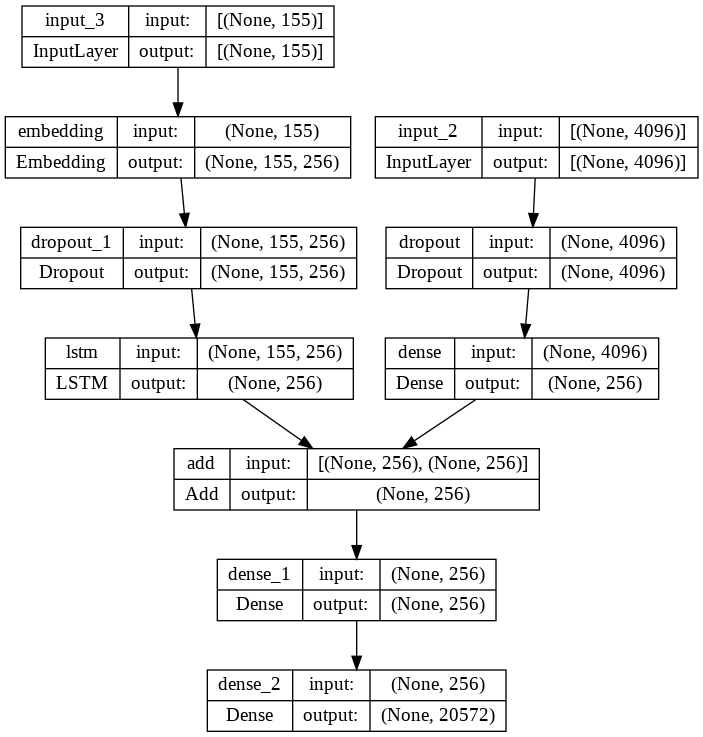

In [ ]:
conv_inputs = Input(shape=(4096,))
fe1 = Dropout(0.4)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs) # try pretrained embedding
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/VizWiz Code/loaded_data/vgg_model5_3.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size
val_steps = len(val) // batch_size

val_gen = data_generator(val, img_to_captions, img_features, tokenizer, max_length, vocab_size, batch_size)

for i in range(epochs):
    gen = data_generator(train, img_to_captions, img_features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(
        gen, 
        epochs=1, 
        validation_data=val_gen, 
        validation_steps=val_steps, 
        steps_per_epoch=steps, 
        callbacks=[tl_checkpoint_1, early_stop], 
        verbose=1)

In [ ]:
conv_inputs = Input(shape=(4096,))
fe1 = Dropout(0.4)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs) # try pretrained embedding
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.load_weights('/content/drive/MyDrive/VizWiz Code/loaded_data/vgg_model5_3.hdf5')
model.compile(optimizer='adam', loss='categorical_crossentropy', )

In [ ]:
# generate captions
def idx_to_word(integer, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == integer: return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        next_word = model.predict([np.array(image), np.array(sequence)], verbose=0)
        next_word = np.argmax(next_word)
        word = idx_to_word(next_word, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq': break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tensorflow as tf

actual, predicted = list(), list()

for key in tqdm(test):
    captions = img_to_captions[key]
    y_pred = predict_caption(model, img_features[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')

100%|██████████| 2495/2495 [33:29<00:00,  1.24it/s]


BLEU-1: 0.45908254282882627
BLEU-2: 0.3085093841266183


In [ ]:
# Visualize the results
from PIL import Image
import matplotlib.pyplot as plt
img_name = test_dict['images'][1400]['file_name']
img_id = test_img_mapping[img_name]
img_path = os.path.join(base_dir, 'test', img_name)
img = Image.open(img_path)
# captions = img_to_captions[img_id]
print('-------------------------Actual-----------------------------')
# for caption in captions:
#     print(caption)

y_pred = predict_caption(model, test_img_features[img_id], tokenizer, max_length)
print('-------------------------Predicted-----------------------------')
print(y_pred)

plt.imshow(img)

In [ ]:
# Visualize the results
from PIL import Image
import matplotlib.pyplot as plt
img_name = test_dict['images'][1]['file_name']
img_id = test_img_mapping[img_name]
img_path = os.path.join(base_dir, 'test', img_name)
img = Image.open(img_path)
y_pred = predict_caption(model, val_img_features[img_id], tokenizer, max_length)
print('-------------------------Predicted-----------------------------')
print(y_pred)

plt.imshow(img)

# **VGG19**

In [ ]:
# Define VGG19 Model
from tensorflow.keras.applications.vgg19 import VGG19
vgg_19 = VGG19()
vgg_19 = Model(inputs=vgg_19.inputs, outputs=vgg_19.layers[-2].output)
vgg_19.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
train_img_features = get_features(vgg_19, 'train', train_img_mapping)
val_img_features = get_features(vgg_19, 'val', val_img_mapping)
test_img_features = get_features(vgg_19, 'test', test_img_mapping)

100%|██████████| 8000/8000 [19:03<00:00,  6.99it/s]


In [ ]:
train_img_features_vgg19_path = os.path.join(loaded_data_path, 'train_img_features_vgg19.pkl')
val_img_features_vgg19_path = os.path.join(loaded_data_path, 'val_img_features_vgg19.pkl')
test_img_features_vgg19_path = os.path.join(loaded_data_path, 'test_img_features_vgg19.pkl')

pickle.dump(test_img_features, open(test_img_features_vgg19_path, 'wb'))
pickle.dump(train_img_features, open(train_img_features_vgg19_path, 'wb'))
pickle.dump(val_img_features, open(val_img_features_vgg19_path, 'wb'))

In [ ]:
train_img_features_vgg19_path = os.path.join(loaded_data_path, 'train_img_features_vgg19.pkl')
val_img_features_vgg19_path = os.path.join(loaded_data_path, 'val_img_features_vgg19.pkl')
test_img_features_vgg19_path = os.path.join(loaded_data_path, 'test_img_features_vgg19.pkl')

with open(train_img_features_vgg19_path, 'rb') as f:
    train_img_features = pickle.load(f)
with open(val_img_features_vgg19_path, 'rb') as f:
    val_img_features = pickle.load(f)
with open(test_img_features_vgg19_path, 'rb') as f:
    test_img_features = pickle.load(f)

In [ ]:
img_features = dict(list(train_img_features.items()) + list(val_img_features.items()))
# img_to_captions = dict(list(train_img_to_captions.items()) + list(val_img_to_captions.items()))

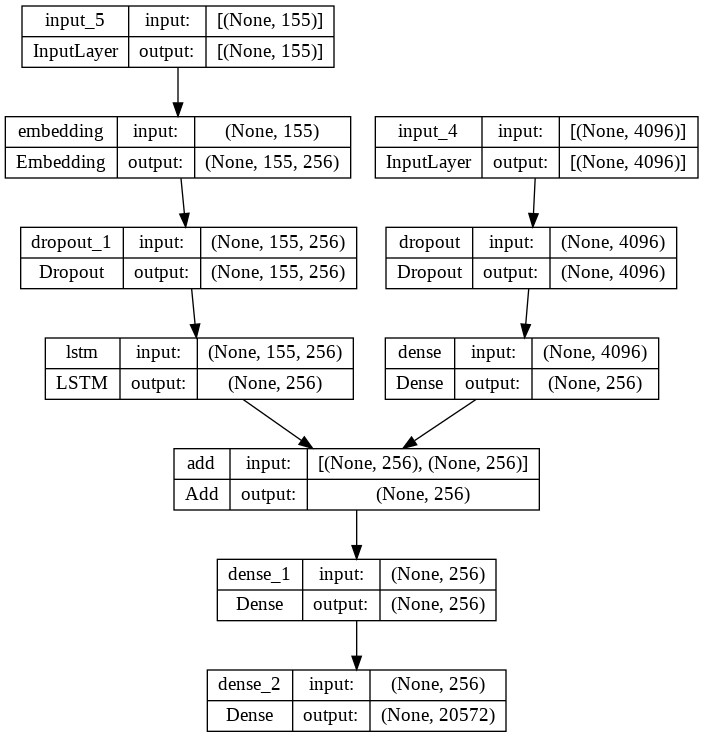

In [ ]:
conv_inputs = Input(shape=(4096,))
fe1 = Dropout(0.5)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs) # try pretrained embedding next
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/VizWiz Code/loaded_data/vgg19_model5_3.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
epochs = 15
batch_size = 32
steps = len(train) // batch_size
val_steps = len(val) // batch_size

val_gen = data_generator(val, img_to_captions, img_features, tokenizer, max_length, vocab_size, batch_size)

for i in range(epochs):
    gen = data_generator(train, img_to_captions, img_features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(
        gen, 
        epochs=1, 
        validation_data=val_gen, 
        validation_steps=val_steps, 
        steps_per_epoch=steps, 
        callbacks=[tl_checkpoint_1, early_stop], 
        verbose=1)

701/701 [==============================] - ETA: 0s - loss: 4.6927
Epoch 1: val_loss improved from inf to 5.19530, saving model to /content/drive/MyDrive/VizWiz Code/loaded_data/vgg19_model5_3.hdf5
701/701 [==============================] - ETA: 0s - loss: 3.7954
Epoch 1: val_loss improved from 5.19530 to 5.11256, saving model to /content/drive/MyDrive/VizWiz Code/loaded_data/vgg19_model5_3.hdf5
701/701 [==============================] - ETA: 0s - loss: 3.5000
Epoch 1: val_loss did not improve from 5.11256
701/701 [==============================] - ETA: 0s - loss: 3.2970
Epoch 1: val_loss did not improve from 5.11256
701/701 [==============================] - ETA: 0s - loss: 3.1400
Epoch 1: val_loss did not improve from 5.11256
701/701 [==============================] - ETA: 0s - loss: 3.0189
Epoch 1: val_loss did not improve from 5.11256
701/701 [==============================] - ETA: 0s - loss: 2.9265
Epoch 1: val_loss did not improve from 5.11256
701/701 [============================

In [ ]:
conv_inputs = Input(shape=(4096,))
fe1 = Dropout(0.4)(conv_inputs)
fe2 = Dense(256, activation='relu')(fe1)

seq_inputs = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(seq_inputs) # try pretrained embedding
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[conv_inputs, seq_inputs], outputs=outputs)
model.load_weights('/content/drive/MyDrive/VizWiz Code/loaded_data/vgg19_model5_3.hdf5')
model.compile(optimizer='adam', loss='categorical_crossentropy', )

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tensorflow as tf

actual, predicted = list(), list()

for key in tqdm(test):
    captions = img_to_captions[key]
    y_pred = predict_caption(model, img_features[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')

100%|██████████| 2495/2495 [54:09<00:00,  1.30s/it]


BLEU-1: 0.34753209778532124
BLEU-2: 0.23195570735436263


In [ ]:
# Visualize the results
from PIL import Image
import matplotlib.pyplot as plt
img_name = test_dict['images'][1400]['file_name']
img_id = test_img_mapping[img_name]
img_path = os.path.join(base_dir, 'test', img_name)
img = Image.open(img_path)
# captions = img_to_captions[img_id]
print('-------------------------Actual-----------------------------')
# for caption in captions:
#     print(caption)

y_pred = predict_caption(model, test_img_features[img_id], tokenizer, max_length)
print('-------------------------Predicted-----------------------------')
print(y_pred)

plt.imshow(img)

In [ ]:
# Visualize the results
from PIL import Image
import matplotlib.pyplot as plt
img_name = test_dict['images'][1]['file_name']
img_id = test_img_mapping[img_name]
img_path = os.path.join(base_dir, 'test', img_name)
img = Image.open(img_path)
y_pred = predict_caption(model, img_features[img_id], tokenizer, max_length)
print('-------------------------Predicted-----------------------------')
print(y_pred)
plt.imshow(img)